In [2]:
import itertools
from typing import Any, Optional

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


import sys, os
from glob import glob

sys.path.append('..')

from tqdm import tqdm
from argparse import ArgumentParser
from easydict import EasyDict
from addict import Dict

from toolz import *
from toolz.curried import *
from itertools import islice, product

import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from data.dataLoader import MakeDataLoader

from model.FFTNet import FFTNet
from model.FFTNet import FFTNet_DSNT
from model.UNet import UNet
from model.DeepLab import DeepLab 
from model.TRANS import TRANS 

from utils import GET_OPTIMIZER
from torchmetrics.functional import dice_score 

from receptivefield.pytorch import PytorchReceptiveField
import skimage

import matplotlib
import matplotlib.pyplot as plt

In [119]:
def getGrad(model,
            inputShape   = [3, 256, 256],
            intermediate = ["logit", "embeded"][0],
            location     = ["center", "all"][0]):
    
    """
    generates a 2D tensor that represents the graident of z(center) resepect to its input    
    * I only get representation at the last layer.      
      this is going to be 1D for FCSN and 2D for a standard segmentation model
      
    * if the location argument is "center", it will zero-out actavtion except the feature at the center.
      if          //           is "all"   , it will it will return gradient for each activation unit.
                  
    """
    
    model.eval()
    model.cuda()
    
    if location == "center" :
                
        gradient = computeGradient(model, inputShape, intermediate)
        gradient = NormalizeGradient(gradient)
        
        return [gradient] # type consistent
    
    if location == "all" :
    
        gradients = [] 
        
        indexes = product(*map(lambda x : range(x))(outShape[1:]))
        
        for idx in indexes:
            
            gradient = computeGradient(model, inputShape, intermediate)
            gradient = NormalizeGradient(gradient)
            
            gradients.append(grandient)
            
        return gradients
    
    
def getOutputShape(model, intermediate, inputShape = [3, 256, 256]):    
        
    with torch.no_grad():
        x = torch.Tensor(1, *inputShape).cuda()
        y = model(x)[intermediate]
        outputShape = y.shape[1:]
        del x, y
    
    return outputShape

def NormalizeGradient(grad):
    grad = np.abs(np.transpose(grad, [0, 2, 3, 1])) # channel last
    return grad / grad.max()

def computeGradient(model, inputShape, intermediate): 
    
    x = torch.zeros(1, *inputShape).cuda().requires_grad_(True)
    #x = torch.randn(1, *inputShape).cuda().requires_grad_(True)
    model.zero_grad()
    
    outShape = getOutputShape(model, intermediate, inputShape)
    
    index = np.array(outShape[1:])//2
    
    y = model(x)[intermediate]
    fm = torch.mean(y, 1, keepdim=True) # average feature   
    mask = torch.zeros(1, *outShape).cuda()
    
    if len(index) == 2:
        mask[:,:, index[0], index[1]] = 1 # to zero-out feature maps not desired
    else:
        mask[:,:, index] = 1 # to zero-out feature maps not desired
    torch.mean(fm * mask).backward()
    
    return x.grad.detach().cpu().numpy() # dy[idx]/dx


def estimate_rf_from_gradient(receptive_field_grad: np.ndarray) :
    
    """
    Given input gradient tensors of shape [N, W, H, C] it returns the
    estimated size of gradient `blob` in W-H directions i.e. this
    function computes the size of gradient in W-H axis for each feature map.
    :param receptive_field_grad: a numpy tensor with gradient values
        obtained for certain feature map
    :return: a corresponding ReceptiveFieldRect
    """

    receptive_field_grad = np.array(receptive_field_grad).mean(0).mean(-1)
    binary_map: np.ndarray = (receptive_field_grad[:, :] > 0)

    x_cs: np.ndarray = binary_map.sum(-1) >= 1
    y_cs: np.ndarray = binary_map.sum(0) >= 1

    x = np.arange(len(x_cs))
    y = np.arange(len(y_cs))

    width = x_cs.sum()
    height = y_cs.sum()

    x = np.sum(x * x_cs) / width
    y = np.sum(y * y_cs) / height

    return (x, y, width, height)


def plot_gradient_field(
    receptive_field_grad: np.ndarray,
    **plot_params
) -> None:
    
    receptive_field = estimate_rf_from_gradient(receptive_field_grad)

    receptive_field_grad = np.array(receptive_field_grad).mean(0).mean(-1)
    receptive_field_grad /= receptive_field_grad.max()
    receptive_field_grad += (np.abs(receptive_field_grad) > 0) * 0.2

    if image is not None:
        receptive_field_grad = np.expand_dims(receptive_field_grad, -1)
        receptive_field_grad = 255 / 2 * (receptive_field_grad + 1) + image * 0.5
        receptive_field_grad = receptive_field_grad.astype("uint8")

    if axis is None:
        figsize = plot_params.get("figsize", (5, 5))
        plt.figure(figsize=figsize)
        axis = plt.subplot(111)

    im = plt.imshow(receptive_field_grad, cmap="coolwarm")
    axis.set_axis_off()
    axis.set_aspect("equal")
    plt.tight_layout()    

def plot_gradient_field(
    receptive_field_grad: np.ndarray,
    image = None,    
    axis: Optional[Any] = None,
    **plot_params
) -> None:
    
    """
    Plot gradient map from gradient tensor.
    :param receptive_field_grad: numpy tensor of shape [N, W, H, C]
    :param image: optional image of shape [W, H, 3]
    :param axis: a matplotlib axis object as returned by the e.g. plt.subplot
        function. If not None then axis is used for visualizations otherwise
        default figure is created.
    :param plot_params: additional plot params: figsize=(5, 5)
    """
    
    receptive_field_grad = np.array(receptive_field_grad).mean(0).mean(-1)
    receptive_field_grad /= receptive_field_grad.max()
    #receptive_field_grad += (np.abs(receptive_field_grad) > 0) * 0.2

    if image is not None:
        receptive_field_grad = np.expand_dims(receptive_field_grad, -1)
        receptive_field_grad = 255 / 2 * (receptive_field_grad + 1) + image * 0.5
        receptive_field_grad = receptive_field_grad.astype("uint8")

    if axis is None:
        figsize = plot_params.get("figsize", (5, 5))
        plt.figure(figsize=figsize)
        axis = plt.subplot(111)

    im = plt.imshow(receptive_field_grad, cmap="gray")    
    plt.tight_layout()
    plt.axis("off")   # turns off axes
    plt.axis("tight")  # gets rid of white border
    plt.axis("image")  #    


In [120]:
def parse(task, model, modelName, encoderName, fold = 0):

    parser = ArgumentParser()

    parser.add_argument("--dataPath", type=str, default="../data/datasets")
    parser.add_argument("--logPath", type=str, default="../log")
    parser.add_argument("--ckptPath", type=str, default="../ckpt")
    parser.add_argument("--visPath", type=str, default="../vis")
    
    # training related    
    parser.add_argument("--augType", type=str, default="aug0", help = "aug0 | aug1")
    
    # hyprer parameter
    parser.add_argument("--inputSize", type=int, default=256)    
    parser.add_argument("--batchN", type=int, default=8)
    parser.add_argument("--epochN", type=int, default=500)
    parser.add_argument("--optimizer", type=str, default="Adam")
    parser.add_argument("--lr", type=float, default= 3e-4)
    parser.add_argument("--weight_decay", type=float, default= 0)
    
    #hardware
    parser.add_argument("--cpuN", type=int, default=4)
    parser.add_argument("--gpuN", type=int, default=1, help = "0|1|2|3")

    config = first(parser.parse_known_args())
    
    config.task        = task
    config.model       = model
    config.modelName   = modelName
    config.encoderName = encoderName
    config.fold        = fold
    
    # pick a gpu that has the largest space
    os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
    os.environ['CUDA_LAUNCH_BLOCKING'] = "3"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpuN)
    
    if config.model == "FFTNet":        
        config.learnSize   = 21
        config.codeSize    = 71        
        net = FFTNet.NETS(config.encoderName, config.inputSize, config.learnSize)

    if config.model == "FFTDSNTNet":        
        config.learnSize   = 21
        config.codeSize    = 71
        config.cov         = 0.1
        net = FFTNet_DSNT.NETS(config.encoderName, config.inputSize, config.learnSize, cov = config.cov)        
        
    if config.model == "UNet":        
        net = UNet.NETS(modelName = config.modelName)
        
    if "DeepLab" in config.model:
        net = DeepLab.NETS(modelName = config.modelName, encoderName = "resnet50", outputStride = 8)
        
    if config.model == "TRANS":
        net = TRANS.NETS()                
        
    return config, net

In [121]:
instances    = [["RIM_DISC", "UNet", "plus", "ignore", "0"],
                ["RIM_DISC", "DeepLab", "plus", "ignore", "0"],
                #["ISIC", "DeepLab_lovasz", "plus", "ignore", "1"],
                ["RIM_DISC", "TRANS", "ignore", "ignore", "0"],                         
                ["RIM_DISC", "FFTDSNTNet", "ignore", "DResNet105", "0"]]

In [122]:
rfs = []
for instance in instances:
    
    config, model = parse(*instance)
    
    print(5*"#" + "(" + ",".join({*instance}) + ")" + "#"*5)
    
    if "FFT" in config.model : ckpt = torch.load(f"{config.ckptPath}/{config.task}/{config.model}/{config.encoderName}/{config.fold}/ckpt.pt")
    else                     : ckpt = torch.load(f"{config.ckptPath}/{config.task}/{config.model}/{config.modelName}/{config.fold}/ckpt.pt")        
    model.load_state_dict(ckpt); model.eval(); model.cuda()
    
    rf = getGrad(model, intermediate = "logit")
        
    rfs.append(rf)

#####(0,plus,RIM_DISC,ignore,UNet)#####
#####(0,plus,RIM_DISC,DeepLab,ignore)#####
#####(TRANS,RIM_DISC,ignore,0)#####
#####(0,DResNet105,RIM_DISC,ignore,FFTDSNTNet)#####


#####(RIM_DISC,ignore,plus,UNet)#####


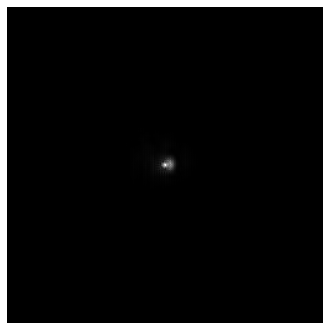

#####(RIM_DISC,DeepLab,ignore,plus)#####


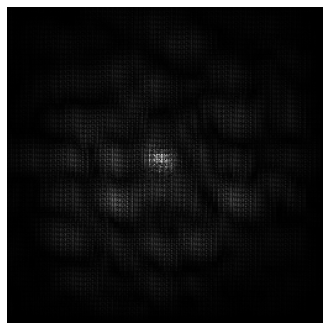

#####(TRANS,RIM_DISC,ignore)#####


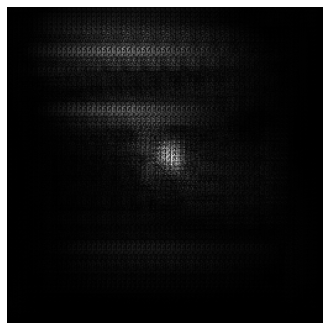

#####(FFTDSNTNet,RIM_DISC,ignore,DResNet105)#####


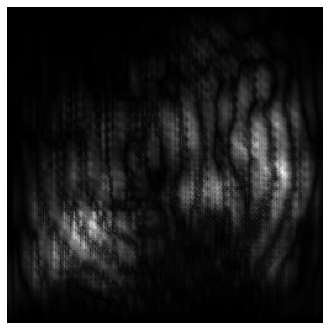

In [123]:
for i, (task, model, modelName, encoderName, fold )in enumerate(instances):
    
    print(5*"#" + "(" + ",".join({task, model, modelName, encoderName}) + ")" + "#"*5)
    
    #plt.imshow(rfs[i][0][0])
    plot_gradient_field(rfs[i][0])
    plt.show()